In [1]:
%matplotlib inline

# Current Satellite Image
see https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_goes16/mapping_GOES16_data.ipynb

In [11]:
from datetime import datetime
import json
import urllib.request

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import metpy.calc as mpcalc
from metpy.plots.ctables import registry
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore

Get satellite data and set projection based on that data.



In [14]:
# Scan the catalog and download the data
satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/catalog.xml')
ds = satcat.datasets[-1]
print(ds)
print(ds.access_urls)
ds = ds.remote_access(use_xarray=True)

OR_ABI-L2-ACHTF-M6_G16_s20200030610217_e20200030619525_c20200030621390.nc
{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20200030610217_e20200030619525_c20200030621390.nc', 'WCS': 'https://thredds.ucar.edu/thredds/wcs/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20200030610217_e20200030619525_c20200030621390.nc', 'WMS': 'https://thredds.ucar.edu/thredds/wms/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20200030610217_e20200030619525_c20200030621390.nc', 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s20200030610217_e20200030619525_c20200030621390.nc', 'HTTPServer': 'https://thredds.ucar.edu/thredds/fileServer/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/OR_ABI-L2-ACHTF-M6_G16_s202000306102

In [37]:
# Trying to find the most recent image from around ~18Z
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes/east/grb/ABI/CONUS/Channel01/current/catalog.xml')
latest_file=cat.datasets[-1]
latest_file_url=latest_file.access_urls['OPENDAP']
print(latest_file_url)
# Access the remote file on the THREDDS server
ds=xr.open_dataset(latest_file_url)

https://thredds-test.unidata.ucar.edu/thredds/dodsC/satellite/goes/east/grb/ABI/CONUS/Channel13/current/OR_ABI-L1b-RadC-M6C13_G16_s20200032246182_e20200032248566_c20200032249085.nc


In [38]:
ds

<xarray.Dataset>
Dimensions:                                           (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
  * y                                                 (y) float32 0.128212 ... 0.044268005
  * x                                                 (x) float32 -0.101332 ... 0.038612
    t                                                 datetime64[ns] ...
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float32 ...
    nominal_satellite_subpoint_lon                    float32 ...
    nominal_satellite_height                          float32 ...
    geospatial_lat_lon_extent                         float32 ...
    yaw_flip_flag                                     float32 ...
    esun                                              float32 ...
    kappa0                                            float32 ...
    planck_fk1                                        float32 ...
    planck_fk2                                        float32 ...
    planck_bc1                                        float32 ...
    planck_bc2                                        float32 ...
    valid_pixel_count                                 float64 ...
    missing_pixel_count                               float64 ...
    saturated_pixel_count                             float64 ...
    undersaturated_pixel_count                        float64 ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    min_radiance_value_of_valid_pixels                float32 ...
    max_radiance_value_of_valid_pixels                float32 ...
    mean_radiance_value_of_valid_pixels               float32 ...
    std_dev_radiance_value_of_valid_pixels            float32 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    percent_uncorrectable_L0_errors                   float32 ...
    earth_sun_distance_anomaly_in_AU                  float32 ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
Attributes:
    naming_authority:                      gov.nesdis.noaa
    Conventions:                           CF-1.7
    Metadata_Conventions:                  Unidata Dataset Discovery v1.0
    standard_name_vocabulary:              CF Standard Name Table (v35, 20 Ju...
    institution:                           DOC/NOAA/NESDIS > U.S. Department ...
    project:                               GOES
    production_site:                       WCDAS
    production_environment:                OE
    spatial_resolution:                    2km at nadir
    orbital_slot:           

In [39]:
# Get projection from satellite data
dat = ds.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs

# Get coordinaates: x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

# Grab time from file and convert to a nice format
vtime=datetime.strptime(ds.time_coverage_end,'%Y-%m-%dT%H:%M:%S.%fZ')

In [42]:
# Get Visible data, convert to reflectance factor and apply gamma correction
vis=np.sqrt(ds.Rad*ds.kappa0)

/home/steidani/miniconda3/envs/weather_2019/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  


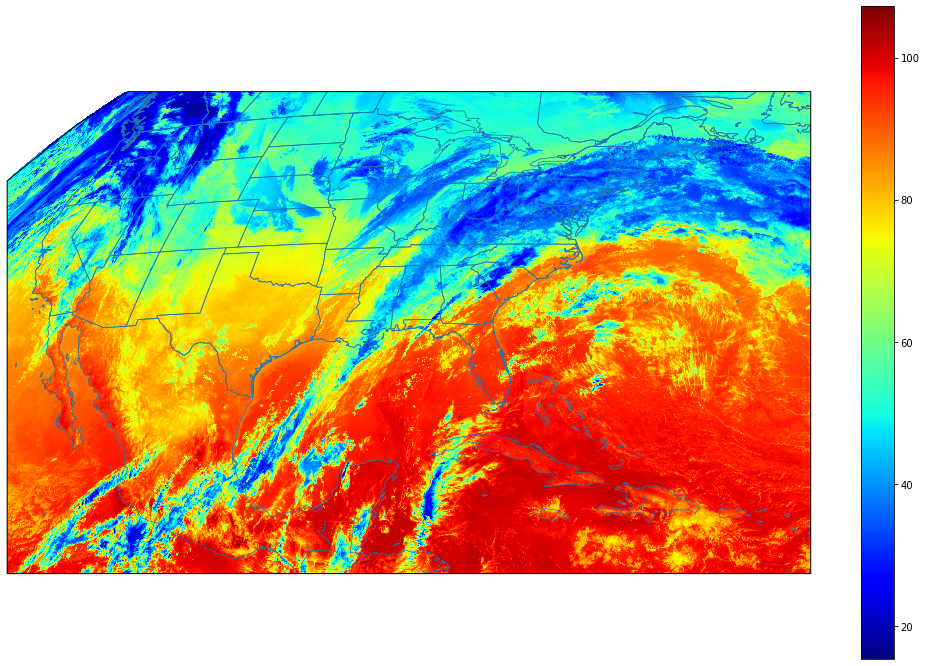

In [45]:
# Start figure and set up projection on axes for plotting
fig=plt.figure(1,figsize=(18,12))
ax=plt.subplot(111,projection=geos)

# Plot geopolitical lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)

# Plot gamma correction visible reflectance values
im = ax.imshow(vis,extent=(x.min(),x.max(),y.min(),y.max()),origin='upper',cmap=plt.cm.Greys_r)
plt.colorbar(im)

plt.tight_layout()
plt.show()